<a href="https://www.kaggle.com/doudouba/elections-predictions-in-czech-republic?scriptVersionId=86345908" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

**1. Introduction**

This report presents a Data Science project with Elections dataset andusing The CRoss Industry
Structured Process for Data Mining (CRISP-DM) methodology.

We will try to answer following questions: 

If there were more people with a college degree in town T, how will it affect the result
for party P?
 Will the town S have the poll turnout above the state/region average?
 Which parties compete for the same voters?
 Which party changes the structure of its electorate the most from 2013 to 2017?

In [1]:
# setup
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.precision", 2)
plt.rcParams['figure.figsize'] = [8, 6]

**2. Data**

The Data Preparation include the preprocessing, the cleaning and transformation of raw data to
clean data that will be used as input data in our model.
The Raw data is loaded in Power BI desktop in UTF8 encoding (to enable the reading of special
characters) and using Power query we perform the data tranformation.
The Raw data (dirty data) is as follows:

• Raw data - 18 214 Ko
• Raw data change type
• Raw data 152 col x over 14764 rows
• Raw data long headers names renamed
• Raw data unnecessary columns removed
• Raw data remove duplicates
• Raw data remove blank rows
• Raw data remove errors

In [2]:
%pip install openpyxl
%pip install xlrd 

     |████████████████████████████████| 242 kB 605 kB/s            
Note: you may need to restart the kernel to use updated packages.
     |████████████████████████████████| 96 kB 739 kB/s            
Note: you may need to restart the kernel to use updated packages.


In [3]:
df = pd.read_excel('../input/clean-data/clean_data.xlsx')

In [4]:
df.head()

,ID_N,municiality_code,municipality_name,District_name,Region,municipality_District_code,municipality_District,P1_17,P2_17,P3_17,...,edu_level_4,edu_level_3,edu_level_2,edulevel_1,Catholics,Employed,Retired_Working_part,Unemployed,Retired_not_working,Weight
0,35,529478,Čakov,Benešov,Středočeský kraj,5.29e+06,529478_1,7.0,0.0,0.0,...,2.0,32.0,28.0,25.0,26.0,47.0,9.0,9.0,26.0,0.17
1,38,529486,Čechtice,Benešov,Středočeský kraj,5.29e+06,529486_3,6.0,0.0,0.0,...,1.0,8.0,21.0,12.0,6.0,18.0,6.0,0.0,16.0,0.08
2,39,529486,Čechtice,Benešov,Středočeský kraj,5.29e+06,529486_4,3.0,0.0,0.0,...,1.0,20.0,30.0,16.0,19.0,33.0,3.0,1.0,28.0,0.12
3,41,529486,Čechtice,Benešov,Středočeský kraj,5.29e+06,529486_6,1.0,0.0,0.0,...,3.0,23.0,35.0,15.0,18.0,47.0,1.0,2.0,26.0,0.15
4,51,529621,Divišov,Benešov,Středočeský kraj,5.30e+06,529621_5,1.0,0.0,0.0,...,1.0,20.0,30.0,30.0,12.0,42.0,7.0,6.0,24.0,0.17


How many rows and columns has the dataframe? 
Answer 14764 rows and 88 colums

In [5]:
df.shape

(14764, 88)

Hypothesis: Let's explore our dataset and see if variables are of the same scale
Conclusion: Our variables are not of the same scale (mean difference = 37, max diff=602) we decide to use scale reduce method to put them at the same scale.  

In [6]:
df[["P1_17","University"]].describe() 

,P1_17,University
count,14745.00,14759.00
mean,38.71,75.08
std,36.24,84.30
min,0.00,0.00
25%,10.00,12.00
50%,29.00,47.00
75%,57.00,109.00
max,431.00,1033.00


**3. Methodology**

Importing packages for PCA and Scale Reduce

In [7]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

In [8]:
df.columns

Index(['ID_N', 'municiality_code', 'municipality_name', 'District_name',
       'Region', 'municipality_District_code', 'municipality_District',
       'P1_17', 'P2_17', 'P3_17', 'P4_17', 'P5_17', 'P6_17', 'P7_17', 'P8_17',
       'P9_17', 'P10_17', 'P11_17', 'P12_17', 'P13_17', 'P14_17', 'P15_17',
       'P16_17', 'P17_17', 'P18_17', 'P19_17', 'P20_17', 'P21_17', 'P22_17',
       'P23_17', 'P24_17', 'P25_17', 'P26_17', 'P27_17', 'P28_17', 'P29_17',
       'P30_17', 'P31_17', 'Total', 'Eligible_voters_17', 'Envelopes_count_17',
       'Valid_votes_count_17', 'P1_13', 'P2_13', 'P3_13', 'P4_13', 'P5_13',
       'P6_13', 'P7_13', 'P8_13', 'P9_13', 'P10_13', 'P11_13', 'P12_13',
       'P13_13', 'P14_13', 'P15_13', 'P16_13', 'P17_13', 'P18_13', 'P19_13',
       'P20_13', 'P21_13', 'P22_13', 'P24_13', 'Eligible_voters_13',
       'Envelopes_count_13', 'Valid_votes_count_13', 'Count_of_buildings',
       'Population_District', 'Male', 'Female', 'Divorced',
       'children_under_14', '65y0plu

In [9]:
import re 

We are selecting the dataset to use for PCA 

In [10]:
col_val_num=re.findall('(P[0-9_]+)|(edu_level_[0-9]+)'," ".join(df.columns.tolist()))

#col_val_num=re.findall('P[0-9_]+'," ".join(df.columns.tolist()))
col_val_num=[i[0]+i[1] for i in col_val_num]
col_val_num.extend(["Catholics", "University","Employed","Unemployed"])
col_val_num

['P1_17',
 'P2_17',
 'P3_17',
 'P4_17',
 'P5_17',
 'P6_17',
 'P7_17',
 'P8_17',
 'P9_17',
 'P10_17',
 'P11_17',
 'P12_17',
 'P13_17',
 'P14_17',
 'P15_17',
 'P16_17',
 'P17_17',
 'P18_17',
 'P19_17',
 'P20_17',
 'P21_17',
 'P22_17',
 'P23_17',
 'P24_17',
 'P25_17',
 'P26_17',
 'P27_17',
 'P28_17',
 'P29_17',
 'P30_17',
 'P31_17',
 'P1_13',
 'P2_13',
 'P3_13',
 'P4_13',
 'P5_13',
 'P6_13',
 'P7_13',
 'P8_13',
 'P9_13',
 'P10_13',
 'P11_13',
 'P12_13',
 'P13_13',
 'P14_13',
 'P15_13',
 'P16_13',
 'P17_13',
 'P18_13',
 'P19_13',
 'P20_13',
 'P21_13',
 'P22_13',
 'P24_13',
 'edu_level_5',
 'edu_level_4',
 'edu_level_3',
 'edu_level_2',
 'Catholics',
 'University',
 'Employed',
 'Unemployed']

In [11]:
df[["Employed", "Unemployed"]]

,Employed,Unemployed
0,47.0,9.0
1,18.0,0.0
2,33.0,1.0
3,47.0,2.0
4,42.0,6.0
...,...,...
14759,719.0,695.0
14760,467.0,43.0
14761,383.0,19.0
14762,321.0,30.0


Prior we want to replace NAN values with the mean of values

In [12]:
X=df[col_val_num]
X=X.fillna(X.mean())

Let's proceed with the scalling

In [13]:
X_cr=scale(X)
X_cr

array([[-0.87557077, -0.47146834, -0.40670883, ..., -0.78401472,
        -1.17651282, -0.88718923],
       [-0.90318017, -0.47146834, -0.40670883, ..., -0.86706685,
        -1.30686224, -1.21096307],
       [-0.98600835, -0.47146834, -0.40670883, ..., -0.85520226,
        -1.23944013, -1.1749882 ],
       ...,
       [ 0.11836744, -0.47146834, -0.40670883, ...,  1.35161142,
         0.3337426 , -0.52744051],
       [ 2.9897445 ,  1.1235301 , -0.40670883, ...,  0.3431213 ,
         0.05506452, -0.13171693],
       [ 0.25641441, -0.47146834, -0.40670883, ...,  2.14653893,
         1.03043781, -0.09574205]])

Here we apply the PCA in 2 axis (2 components)

In [14]:
pca=PCA(n_components=2)
X=pca.fit_transform(X_cr)

In [15]:
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.34258194 0.07723984]
[559.98977109 265.90012479]


We notice a PCA of 39 % wich is not good because we were aiming for 80% minimum the maximum and bet value being 100%

In [16]:
#Let's look at the shape of our new data set
X.shape

(14764, 2)

Let's plot result from PCA to see the variance 

In [17]:
x=[i[0] for i in X]
y=[i[1] for i in X]

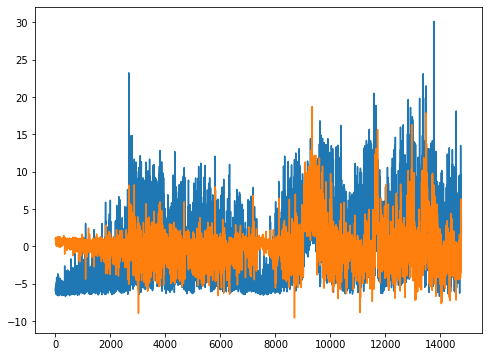

In [18]:
plt.plot(X)

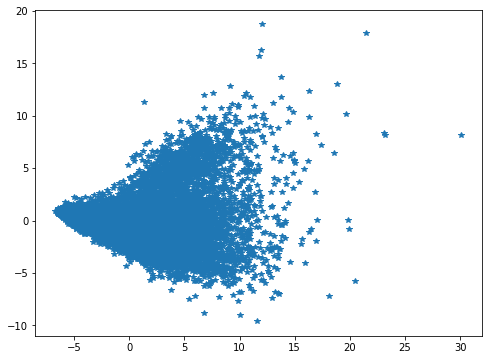

In [19]:
plt.plot(x,y, "*") 

Result: We notice a compact group and some noises we suggest to remove and proceed with clustering 

In [20]:
#Isolation forest to remove the noise 
from sklearn.ensemble import IsolationForest
clf = IsolationForest(random_state=0).fit_predict(X_cr)

In [21]:
#index of noises to remove 
clf[clf==-1]
index_to_remove=[i for i in range(len(df)) if clf[i]==-1]

index_to_remove

[2664,
 2666,
 2670,
 2676,
 2722,
 2745,
 2746,
 2753,
 2761,
 2776,
 2782,
 2783,
 2812,
 2852,
 2864,
 2866,
 2867,
 2876,
 2878,
 2888,
 2916,
 2927,
 2960,
 3035,
 3039,
 3079,
 3085,
 3122,
 3222,
 3277,
 3278,
 3293,
 3298,
 3304,
 3310,
 3323,
 3352,
 3374,
 3388,
 3395,
 3396,
 3400,
 3423,
 3427,
 3556,
 3583,
 3588,
 3677,
 3689,
 3779,
 3782,
 3783,
 3799,
 3805,
 3863,
 3892,
 3915,
 3933,
 4330,
 4339,
 4382,
 4682,
 4837,
 5209,
 5291,
 5399,
 5436,
 5605,
 5720,
 5809,
 6320,
 6332,
 8296,
 8338,
 8467,
 8564,
 8587,
 8596,
 8693,
 8710,
 8725,
 8730,
 8734,
 8740,
 8753,
 8797,
 8817,
 8819,
 8860,
 8867,
 8882,
 8901,
 8938,
 8987,
 9066,
 9083,
 9118,
 9137,
 9142,
 9171,
 9179,
 9182,
 9199,
 9201,
 9208,
 9209,
 9212,
 9216,
 9218,
 9223,
 9236,
 9237,
 9239,
 9244,
 9276,
 9278,
 9295,
 9297,
 9298,
 9303,
 9304,
 9307,
 9308,
 9311,
 9312,
 9313,
 9317,
 9318,
 9322,
 9329,
 9333,
 9334,
 9352,
 9356,
 9357,
 9365,
 9381,
 9387,
 9388,
 9400,
 9406,
 9413,
 9415,

With following function we remove noises from our dataset and repeat the PCA and proceed with clutering

In [22]:
df.drop(index_to_remove, axis=0, inplace=True)

In [23]:
X=df[col_val_num]
X=X.fillna(X.mean())
X_cr=scale(X)
X_cr

array([[-0.91613388, -0.47413638, -0.38995074, ..., -0.79407309,
        -1.19453964, -0.86784966],
       [-0.94852436, -0.47413638, -0.38995074, ..., -0.88764149,
        -1.33585963, -1.1989904 ],
       [-1.04569578, -0.47413638, -0.38995074, ..., -0.87427458,
        -1.26276309, -1.16219699],
       ...,
       [ 0.24992324, -0.47413638, -0.38995074, ...,  1.61197154,
         0.44282298, -0.4999155 ],
       [ 3.61853269,  1.23299542, -0.38995074, ...,  0.4757838 ,
         0.14069059, -0.09518793],
       [ 0.41187561, -0.47413638, -0.38995074, ...,  2.50755482,
         1.19815395, -0.05839451]])

In [24]:
pca=PCA(n_components=2)
X=pca.fit_transform(X_cr)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.33391649 0.07194619]
[542.12292235 251.64176973]


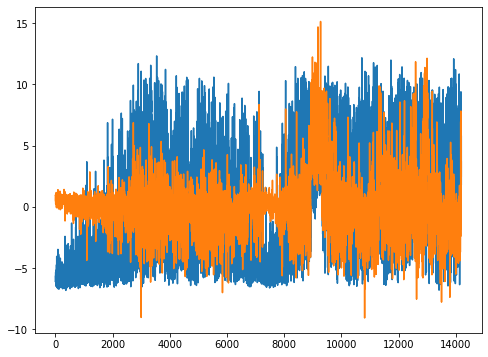

In [25]:
x=[i[0] for i in X]
y=[i[1] for i in X]
plt.plot(X)

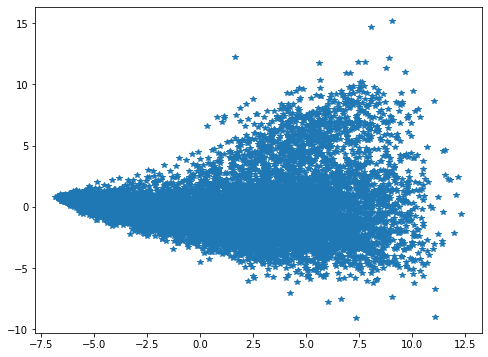

In [26]:
plt.plot(x,y, "*") 

We now proceed with the CAH clustering with ward method and eucidiand metric. We start wih a treshold of 0 and will decide to increase it according to the result

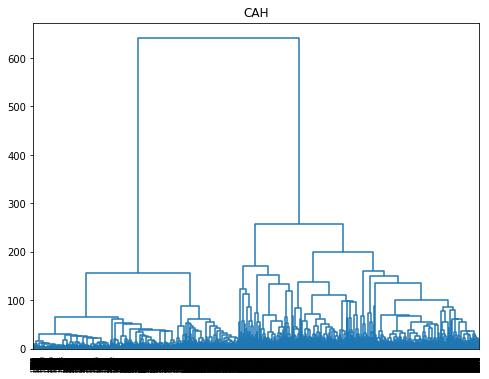

In [27]:
#librairies for CAH
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
#générer la matrice des liens
Z = linkage(X_cr,method='ward',metric='euclidean')
#affichage du dendrogramme
plt.title("CAH")
dendrogram(Z,labels=df.index,orientation='top',color_threshold=0)
plt.show()

#work on methods and metrics
#change treshlold accordingly 
#with a treshold 0 we notice ... 

We use KMeans to decide on how we should cluster 

[0.28195831 0.26320057 0.20461235 0.19617821 0.1649624 ]


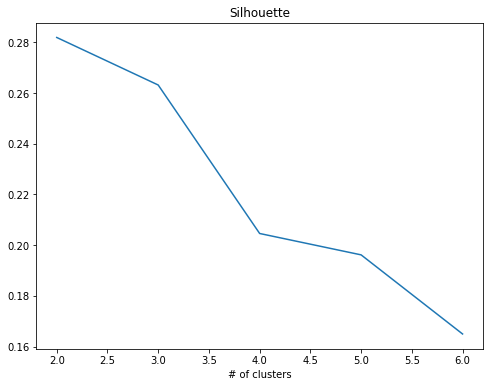

In [28]:
#librairies to evaluate the partitions
from sklearn import metrics, cluster
#utilisation de la métrique "silhouette"
#faire varier le nombre de clusters de 2 à 7
res = np.arange(5,dtype="double")
for k in np.arange(5):
    km = cluster.KMeans(n_clusters=k+2)
    km.fit(X_cr)
    res[k] = metrics.silhouette_score(X_cr,km.labels_)
print(res)
#graphique
import matplotlib.pyplot as plt
plt.title("Silhouette")
plt.xlabel("# of clusters")
plt.plot(np.arange(2,7,1),res)
plt.show()

Result show we should use a 2 clusters because it's higher value

In [29]:
kmeans = cluster.KMeans(n_clusters=2)
kmeans.fit(X_cr)
#index triés des groupes
idk = np.argsort(kmeans.labels_)
#affichage des observations et leurs groupes
print(pd.DataFrame(df.index[idk],kmeans.labels_[idk]))
#distances aux centres de classes des observations
print(kmeans.transform(X_cr))
#correspondance avec les groupes de la CAH
#pd.crosstab(groupes_cah,kmeans.labels_)

        0
0   14763
0    5350
0    5349
0    5348
0   10788
..    ...
1    5901
1    5906
1    5908
1    5914
1    7169

[14196 rows x 1 columns]
[[ 9.83259262  2.17155131]
 [10.44670512  3.148237  ]
 [11.32399851  5.64783004]
 ...
 [ 6.02797379  7.89040377]
 [ 7.52137185 12.11955121]
 [ 5.14748875  7.42476551]]


Then we set the treshold to 250

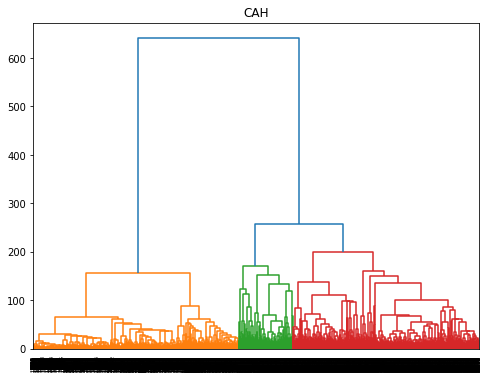

In [30]:
#librairies for CAH
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
#générer la matrice des liens
Z = linkage(X_cr,method='ward',metric='euclidean')
#affichage du dendrogramme
plt.title("CAH")
dendrogram(Z,labels=df.index,orientation='top',color_threshold=250)
plt.show()

#work on methods and metrics
#change treshlold accordingly 

In [31]:
#we removed 
len(index_to_remove)

568

Let's look at how much groups we have

In [32]:
from scipy.cluster.hierarchy import fcluster
groupes_cah = fcluster(Z,t=150,criterion='distance')
print(groupes_cah)

[1 1 1 ... 5 5 8]


Results show we have 7 groups that we will try to represent 

In [33]:
np.unique(groupes_cah)


array([1, 2, 3, 4, 5, 6, 7, 8], dtype=int32)

In [34]:
df.head()

,ID_N,municiality_code,municipality_name,District_name,Region,municipality_District_code,municipality_District,P1_17,P2_17,P3_17,...,edu_level_4,edu_level_3,edu_level_2,edulevel_1,Catholics,Employed,Retired_Working_part,Unemployed,Retired_not_working,Weight
0,35,529478,Čakov,Benešov,Středočeský kraj,5.29e+06,529478_1,7.0,0.0,0.0,...,2.0,32.0,28.0,25.0,26.0,47.0,9.0,9.0,26.0,0.17
1,38,529486,Čechtice,Benešov,Středočeský kraj,5.29e+06,529486_3,6.0,0.0,0.0,...,1.0,8.0,21.0,12.0,6.0,18.0,6.0,0.0,16.0,0.08
2,39,529486,Čechtice,Benešov,Středočeský kraj,5.29e+06,529486_4,3.0,0.0,0.0,...,1.0,20.0,30.0,16.0,19.0,33.0,3.0,1.0,28.0,0.12
3,41,529486,Čechtice,Benešov,Středočeský kraj,5.29e+06,529486_6,1.0,0.0,0.0,...,3.0,23.0,35.0,15.0,18.0,47.0,1.0,2.0,26.0,0.15
4,51,529621,Divišov,Benešov,Středočeský kraj,5.30e+06,529621_5,1.0,0.0,0.0,...,1.0,20.0,30.0,30.0,12.0,42.0,7.0,6.0,24.0,0.17


Let's control if there are no duplicated in our ID_N
result: No duplicates found

In [35]:
len(np.unique(df[["ID_N"]]))
len(np.unique(df[["ID_N"]]))/len(df[["ID_N"]]) #no duplicated ID good

1.0

Let's recupere our groups now we have 9 groups in lists

In [36]:

import collections as clt 

dict_group=clt.defaultdict(list)

for i in range(len(groupes_cah)):
    g=groupes_cah[i]
    idn=int(df[["ID_N"]].values[i])
    dict_group[g].append(idn)
    


In [37]:
dict_group[8]

[7479,
 7533,
 7699,
 10721,
 13349,
 9054,
 12123,
 12089,
 4907,
 7369,
 1130,
 1686,
 2509,
 1658,
 7810,
 10441,
 1611,
 7360,
 7783,
 9154,
 10508,
 4919,
 12782,
 8011,
 11475,
 2496,
 2582,
 2870,
 5850,
 6066,
 7373,
 7397,
 8161,
 9171,
 11321,
 11635,
 12116,
 12540,
 12742,
 13242,
 13474,
 4899,
 7260,
 12967,
 13340,
 200,
 6046,
 7274,
 11345,
 11637,
 12882,
 8134,
 1472,
 4359,
 9190,
 11955,
 13558,
 5832,
 7604,
 11065,
 12591,
 12618,
 12849,
 659,
 2093,
 4136,
 9105,
 11513,
 12543,
 12958,
 413,
 170,
 5012,
 7661,
 7752,
 7807,
 8238,
 9162,
 10583,
 11506,
 12270,
 7975,
 419,
 4718,
 12871,
 13525,
 3091,
 4672,
 11457,
 12832,
 13468,
 7953,
 7024,
 8253,
 10982,
 11226,
 12287,
 12304,
 13604,
 4502,
 4682,
 5625,
 1757,
 5989,
 7856,
 11293,
 11476,
 357,
 11426,
 13363,
 9317,
 5915,
 2320,
 3408,
 3443,
 4774,
 4904,
 4913,
 6053,
 6324,
 6872,
 7677,
 7812,
 7951,
 8061,
 10325,
 10511,
 4432,
 5914,
 4487,
 10658,
 7406,
 9286,
 11339,
 2554,
 2989,
 460

With dict_group[n] we took all the idn and grouped them by cluster. We are now putting them in a list according to the municipality name

In [38]:
dict_villes=clt.defaultdict(list)
for i in range(1,8):
    dict_villes[i]= np.unique(df[df["ID_N"].isin(dict_group[i])]['municipality_name'].values.tolist())
    

Let's find intersections between our clusters. Example between Cluster 1 and Cluster 2 we try to see what municipality they share together

In [39]:
#intersection between town 1 and 2 
set(dict_villes[1]).intersection(set(dict_villes[2]))

{'Albrechtice nad Vltavou',
 'Aš',
 'Babice',
 'Bakov nad Jizerou',
 'Benecko',
 'Benešov',
 'Benátky nad Jizerou',
 'Beroun',
 'Bezděkov',
 'Bečváry',
 'Blansko',
 'Blovice',
 'Bobnice',
 'Boharyně',
 'Bohdalice-Pavlovice',
 'Bohdíkov',
 'Bohumín',
 'Bohuslavice',
 'Bolešiny',
 'Borotice',
 'Borovnice',
 'Boskovice',
 'Bratronice',
 'Broumov',
 'Brumovice',
 'Bruntál',
 'Buk',
 'Buková',
 'Bušovice',
 'Bystřice',
 'Bystřice nad Pernštejnem',
 'Bystřice pod Hostýnem',
 'Bílov',
 'Bílovec',
 'Bílá',
 'Bítov',
 'Býšť',
 'Bělá pod Bezdězem',
 'Běrunice',
 'Běšiny',
 'Břasy',
 'Březina',
 'Březová',
 'Březí',
 'Břežany',
 'Cheb',
 'Chlum',
 'Chlum u Třeboně',
 'Chlumec nad Cidlinou',
 'Chlumčany',
 'Chlístov',
 'Chlístovice',
 'Chocnějovice',
 'Chodouny',
 'Chodov',
 'Chodský Újezd',
 'Chotěboř',
 'Chotěšov',
 'Choustník',
 'Chrast',
 'Chrudim',
 'Chvalkovice',
 'Chvalovice',
 'Chválenice',
 'Cvikov',
 'Církvice',
 'Dalešice',
 'Dačice',
 'Dešenice',
 'Dešná',
 'Divišov',
 'Dlouhá Lhota',


No Let's try to find what municipality are in cluster 1 but are not in any other cluster 

In [40]:
#what is in group 1 that is not in others
set(dict_villes[1]).difference(set(dict_villes[2,3,4,5,6,7]))

{'Nadryby',
 'Borek',
 'Klenová',
 'Hřebečníky',
 'Hřensko',
 'Lednice',
 'Děčín',
 'Záboří nad Labem',
 'Vladislav',
 'Sběř',
 'Loukovec',
 'Pustá Kamenice',
 'Přítluky',
 'Košíky',
 'Jamolice',
 'Kolaje',
 'Třinec',
 'Smidary',
 'Velenice',
 'Merklín',
 'Dobrkovice',
 'Časy',
 'Tuhaň',
 'Zvěřínek',
 'České Velenice',
 'Mezholezy',
 'Újezd u Plánice',
 'Homole u Panny',
 'Hoslovice',
 'Radkovice u Budče',
 'Milíčovice',
 'Oudoleň',
 'Strachujov',
 'Světce',
 'Budiměřice',
 'Břvany',
 'Ratiboř',
 'Klatovy',
 'Křenovy',
 'Velký Rybník',
 'Perálec',
 'Blatná',
 'Mostek',
 'Klobuky',
 'Čečelovice',
 'Zbraslavice',
 'Roprachtice',
 'Třebom',
 'Čeradice',
 'Ostroměř',
 'Beřovice',
 'Kunratice',
 'Rohozec',
 'Kostelní Myslová',
 'Valašské Meziříčí',
 'Bačkov',
 'Říčany',
 'Choratice',
 'Staré Hutě',
 'Křišťanovice',
 'Skrchov',
 'Křekov',
 'Svépravice',
 'Vinary',
 'Kuňovice',
 'Polště',
 'Horosedly',
 'Stříbřec',
 'Březí nad Oslavou',
 'Žítková',
 'Kružberk',
 'Polní Chrčice',
 'Šedivec',
 

Municipalities are shared only by political parties and voters in group 1 meaning they will never be won by political parties from other clusters

**Now Let's try a different approach using Correlation and Linear regression**

Let's split and reduce our dataset.
data reduction: Split to smaller dataset easier to handle
data reduction: split to train and test set

In [41]:
df_region=df.iloc[:,2:5]

df_17 = df.iloc[:, 7:39]

df_13=df.iloc[:,42:68]

df_population=df.iloc[:,69:76]

df_education=df.iloc[:,76:82]

df_religion=df.iloc[:,82:83]

df_employment=df.iloc[:,84:87]

df_region,df_17,df_13,df_population,df_education,df_religion,df_employment,df_religion,df_population

(      municipality_name District_name            Region
 0                 Čakov       Benešov  Středočeský kraj
 1              Čechtice       Benešov  Středočeský kraj
 2              Čechtice       Benešov  Středočeský kraj
 3              Čechtice       Benešov  Středočeský kraj
 4               Divišov       Benešov  Středočeský kraj
 ...                 ...           ...               ...
 14759   Praha-Kolovraty         Praha             Praha
 14760   Praha-Královice         Praha             Praha
 14761    Praha-Zbraslav         Praha             Praha
 14762          Praha 19         Praha             Praha
 14763          Praha 14         Praha             Praha
 
 [14196 rows x 3 columns],
        P1_17  P2_17  P3_17  P4_17  P5_17  P6_17  P7_17  P8_17  P9_17  P10_17  \
 0        7.0    0.0    0.0    6.0    0.0    0.0    8.0    3.0    0.0     0.0   
 1        6.0    0.0    0.0    2.0    0.0    0.0    2.0    5.0    0.0     0.0   
 2        3.0    0.0    0.0    2.0    0.0   

To understand more the data let's find relationship using pearso corelation and plot it using  background diagram

In [42]:
import matplotlib.pyplot as plt

Let's find relationship between education and decision of voting for a political party

In [43]:
df_edu=pd.concat([df_education,df_17], axis=1)

In [44]:
import seaborn as sns
corr_df = df_edu.corr(method='pearson')

In [45]:
corr_df.style.background_gradient(cmap='coolwarm')

,University,edu_level_5,edu_level_4,edu_level_3,edu_level_2,edulevel_1,P1_17,P2_17,P3_17,P4_17,P5_17,P6_17,P7_17,P8_17,P9_17,P10_17,P11_17,P12_17,P13_17,P14_17,P15_17,P16_17,P17_17,P18_17,P19_17,P20_17,P21_17,P22_17,P23_17,P24_17,P25_17,P26_17,P27_17,P28_17,P29_17,P30_17,P31_17,Total
University,1.00,0.83,0.80,0.82,0.46,0.38,0.77,0.11,0.19,0.55,0.26,0.11,0.38,0.37,0.71,0.21,0.18,0.62,0.14,0.28,0.79,0.08,0.04,0.03,0.14,0.77,0.54,0.14,0.13,0.40,0.10,0.56,0.28,0.07,0.46,0.22,0.08,0.72
edu_level_5,0.83,1.00,0.79,0.82,0.56,0.47,0.71,0.16,0.18,0.57,0.24,0.12,0.42,0.44,0.65,0.29,0.16,0.60,0.15,0.27,0.77,0.08,0.06,0.01,0.15,0.70,0.58,0.13,0.17,0.35,0.11,0.51,0.27,0.12,0.48,0.22,0.05,0.72
edu_level_4,0.80,0.79,1.00,0.92,0.73,0.63,0.74,0.21,0.21,0.73,0.15,0.16,0.47,0.60,0.67,0.38,0.13,0.64,0.19,0.32,0.78,0.05,0.04,0.03,0.18,0.64,0.76,0.17,0.25,0.43,0.13,0.55,0.30,0.18,0.67,0.29,0.05,0.85
edu_level_3,0.82,0.82,0.92,1.00,0.83,0.73,0.78,0.24,0.22,0.78,0.14,0.19,0.51,0.67,0.69,0.44,0.11,0.69,0.22,0.35,0.83,0.06,0.05,0.04,0.20,0.65,0.84,0.18,0.28,0.48,0.14,0.59,0.34,0.21,0.76,0.33,0.07,0.92
edu_level_2,0.46,0.56,0.73,0.83,1.00,0.92,0.57,0.29,0.19,0.78,0.00,0.21,0.48,0.79,0.49,0.56,0.01,0.54,0.26,0.30,0.61,0.02,0.03,0.05,0.21,0.34,0.89,0.17,0.36,0.48,0.13,0.43,0.32,0.32,0.86,0.36,0.07,0.86
edulevel_1,0.38,0.47,0.63,0.73,0.92,1.00,0.47,0.29,0.15,0.69,-0.01,0.17,0.39,0.73,0.43,0.52,-0.00,0.45,0.25,0.27,0.50,0.01,0.02,0.06,0.20,0.27,0.79,0.14,0.35,0.41,0.13,0.36,0.26,0.32,0.80,0.33,0.07,0.75
P1_17,0.77,0.71,0.74,0.78,0.57,0.47,1.00,0.18,0.20,0.60,0.19,0.15,0.50,0.46,0.70,0.35,0.13,0.69,0.18,0.34,0.85,0.07,0.07,0.01,0.18,0.79,0.65,0.15,0.20,0.44,0.12,0.58,0.32,0.13,0.54,0.24,0.08,0.84
P2_17,0.11,0.16,0.21,0.24,0.29,0.29,0.18,1.00,0.05,0.22,-0.01,0.06,0.17,0.24,0.14,0.19,-0.00,0.20,0.10,0.11,0.20,0.01,0.04,0.00,0.08,0.10,0.27,0.03,0.13,0.10,0.02,0.14,0.10,0.12,0.26,0.13,0.02,0.27
P3_17,0.19,0.18,0.21,0.22,0.19,0.15,0.20,0.05,1.00,0.18,0.03,0.06,0.15,0.15,0.18,0.11,0.01,0.18,0.05,0.10,0.22,0.01,0.02,0.00,0.04,0.17,0.21,0.07,0.08,0.14,0.03,0.16,0.08,0.04,0.19,0.10,0.02,0.24
P4_17,0.55,0.57,0.73,0.78,0.78,0.69,0.60,0.22,0.18,1.00,0.05,0.22,0.38,0.73,0.51,0.46,0.03,0.54,0.21,0.28,0.62,0.03,0.02,0.06,0.19,0.39,0.81,0.15,0.28,0.52,0.13,0.46,0.33,0.23,0.76,0.32,0.11,0.84


Results show that educated people have tendency to vote for following political partys: P20, P15, P12, P9, P1 (red)

Now we explore the Relationship between religion and decision of voting for a political party

In [46]:

df_relg=pd.concat([df_religion,df_17], axis=1)
import seaborn as sns
corr_df = df_relg.corr(method='pearson')
corr_df.style.background_gradient(cmap='coolwarm')

,Catholics,P1_17,P2_17,P3_17,P4_17,P5_17,P6_17,P7_17,P8_17,P9_17,P10_17,P11_17,P12_17,P13_17,P14_17,P15_17,P16_17,P17_17,P18_17,P19_17,P20_17,P21_17,P22_17,P23_17,P24_17,P25_17,P26_17,P27_17,P28_17,P29_17,P30_17,P31_17,Total
Catholics,1.00,0.37,0.10,0.11,0.55,-0.00,0.17,0.25,0.41,0.29,0.26,-0.00,0.34,0.12,0.13,0.35,-0.03,-0.03,0.03,0.12,0.21,0.49,0.09,0.14,0.86,0.06,0.27,0.21,0.09,0.52,0.27,0.13,0.56
P1_17,0.37,1.00,0.18,0.20,0.60,0.19,0.15,0.50,0.46,0.70,0.35,0.13,0.69,0.18,0.34,0.85,0.07,0.07,0.01,0.18,0.79,0.65,0.15,0.20,0.44,0.12,0.58,0.32,0.13,0.54,0.24,0.08,0.84
P2_17,0.10,0.18,1.00,0.05,0.22,-0.01,0.06,0.17,0.24,0.14,0.19,-0.00,0.20,0.10,0.11,0.20,0.01,0.04,0.00,0.08,0.10,0.27,0.03,0.13,0.10,0.02,0.14,0.10,0.12,0.26,0.13,0.02,0.27
P3_17,0.11,0.20,0.05,1.00,0.18,0.03,0.06,0.15,0.15,0.18,0.11,0.01,0.18,0.05,0.10,0.22,0.01,0.02,0.00,0.04,0.17,0.21,0.07,0.08,0.14,0.03,0.16,0.08,0.04,0.19,0.10,0.02,0.24
P4_17,0.55,0.60,0.22,0.18,1.00,0.05,0.22,0.38,0.73,0.51,0.46,0.03,0.54,0.21,0.28,0.62,0.03,0.02,0.06,0.19,0.39,0.81,0.15,0.28,0.52,0.13,0.46,0.33,0.23,0.76,0.32,0.11,0.84
P5_17,-0.00,0.19,-0.01,0.03,0.05,1.00,-0.01,0.07,-0.00,0.21,-0.01,0.17,0.14,0.01,0.04,0.27,0.08,0.01,-0.01,0.02,0.32,0.03,0.01,-0.02,0.03,0.03,0.13,0.05,-0.03,-0.02,0.03,-0.01,0.12
P6_17,0.17,0.15,0.06,0.06,0.22,-0.01,1.00,0.08,0.20,0.10,0.13,-0.02,0.13,0.04,0.06,0.15,0.02,0.00,0.02,0.04,0.08,0.21,0.06,0.06,0.18,0.05,0.12,0.11,0.06,0.20,0.08,0.02,0.22
P7_17,0.25,0.50,0.17,0.15,0.38,0.07,0.08,1.00,0.34,0.38,0.29,0.04,0.42,0.14,0.21,0.52,0.02,0.09,-0.02,0.11,0.42,0.48,0.11,0.16,0.26,0.09,0.33,0.18,0.10,0.40,0.17,0.00,0.59
P8_17,0.41,0.46,0.24,0.15,0.73,-0.00,0.20,0.34,1.00,0.39,0.49,-0.00,0.44,0.22,0.25,0.49,0.02,0.02,0.05,0.18,0.24,0.78,0.15,0.32,0.37,0.13,0.38,0.29,0.27,0.75,0.31,0.08,0.75
P9_17,0.29,0.70,0.14,0.18,0.51,0.21,0.10,0.38,0.39,1.00,0.28,0.15,0.58,0.15,0.30,0.74,0.07,0.04,0.01,0.15,0.70,0.54,0.13,0.17,0.36,0.10,0.50,0.26,0.12,0.47,0.22,0.07,0.70


Results show that catholics vote for political party P24, which is a catholic party

*Now we explore relationship between sexe and decision of voting for a particular political party*

In [47]:
df_pop=pd.concat([df_population,df_17], axis=1)
corr_df = df_pop.corr(method='pearson')
corr_df.style.background_gradient(cmap='coolwarm')

,Population_District,Male,Female,Divorced,children_under_14,65y0plus,RomaPeople,P1_17,P2_17,P3_17,P4_17,P5_17,P6_17,P7_17,P8_17,P9_17,P10_17,P11_17,P12_17,P13_17,P14_17,P15_17,P16_17,P17_17,P18_17,P19_17,P20_17,P21_17,P22_17,P23_17,P24_17,P25_17,P26_17,P27_17,P28_17,P29_17,P30_17,P31_17,Total
Population_District,1.00,1.00,1.00,0.89,0.94,0.82,0.06,0.73,0.27,0.21,0.78,0.12,0.19,0.50,0.72,0.66,0.49,0.09,0.65,0.25,0.34,0.78,0.05,0.05,0.05,0.21,0.58,0.86,0.18,0.32,0.48,0.15,0.55,0.34,0.27,0.81,0.35,0.07,0.92
Male,1.00,1.00,0.98,0.88,0.94,0.79,0.07,0.72,0.27,0.21,0.77,0.11,0.19,0.50,0.72,0.64,0.49,0.08,0.64,0.25,0.33,0.77,0.05,0.05,0.05,0.21,0.57,0.86,0.17,0.32,0.48,0.14,0.54,0.33,0.27,0.81,0.35,0.07,0.91
Female,1.00,0.98,1.00,0.90,0.93,0.83,0.06,0.73,0.27,0.21,0.79,0.12,0.19,0.50,0.72,0.66,0.49,0.09,0.65,0.24,0.34,0.78,0.05,0.04,0.05,0.21,0.58,0.86,0.18,0.32,0.48,0.15,0.55,0.34,0.26,0.81,0.35,0.07,0.92
Divorced,0.89,0.88,0.90,1.00,0.80,0.74,0.07,0.59,0.25,0.18,0.65,0.12,0.12,0.39,0.61,0.61,0.41,0.10,0.56,0.22,0.31,0.68,0.05,0.03,0.05,0.19,0.51,0.73,0.15,0.30,0.24,0.13,0.48,0.27,0.25,0.70,0.29,0.05,0.76
children_under_14,0.94,0.94,0.93,0.80,1.00,0.68,0.10,0.67,0.27,0.21,0.72,0.06,0.19,0.49,0.68,0.58,0.49,0.05,0.59,0.24,0.32,0.70,0.03,0.05,0.04,0.20,0.50,0.81,0.16,0.32,0.46,0.14,0.49,0.31,0.27,0.79,0.33,0.06,0.85
65y0plus,0.82,0.79,0.83,0.74,0.68,1.00,0.03,0.66,0.22,0.18,0.73,0.11,0.17,0.43,0.65,0.58,0.40,0.09,0.55,0.19,0.30,0.66,0.05,0.03,0.04,0.18,0.53,0.75,0.16,0.25,0.46,0.13,0.48,0.29,0.20,0.65,0.30,0.07,0.80
RomaPeople,0.06,0.07,0.06,0.07,0.10,0.03,1.00,0.01,0.02,0.01,0.02,-0.00,0.00,0.00,0.03,0.02,0.02,-0.00,0.01,0.01,0.01,0.01,-0.00,-0.00,0.01,0.01,0.01,0.02,0.00,0.01,-0.01,0.01,0.02,-0.00,0.03,0.03,0.01,-0.01,0.02
P1_17,0.73,0.72,0.73,0.59,0.67,0.66,0.01,1.00,0.18,0.20,0.60,0.19,0.15,0.50,0.46,0.70,0.35,0.13,0.69,0.18,0.34,0.85,0.07,0.07,0.01,0.18,0.79,0.65,0.15,0.20,0.44,0.12,0.58,0.32,0.13,0.54,0.24,0.08,0.84
P2_17,0.27,0.27,0.27,0.25,0.27,0.22,0.02,0.18,1.00,0.05,0.22,-0.01,0.06,0.17,0.24,0.14,0.19,-0.00,0.20,0.10,0.11,0.20,0.01,0.04,0.00,0.08,0.10,0.27,0.03,0.13,0.10,0.02,0.14,0.10,0.12,0.26,0.13,0.02,0.27
P3_17,0.21,0.21,0.21,0.18,0.21,0.18,0.01,0.20,0.05,1.00,0.18,0.03,0.06,0.15,0.15,0.18,0.11,0.01,0.18,0.05,0.10,0.22,0.01,0.02,0.00,0.04,0.17,0.21,0.07,0.08,0.14,0.03,0.16,0.08,0.04,0.19,0.10,0.02,0.24


Result:
Men as well as Women have tendency to vote for party P29, P21, P15, P12, P8, P4, P1
Divorced People have the same tendency as well as Men and Women
People of age over 65 would vote for P1, P4, P21  while Roma People seem not have impact to the elections issues

*Relationship between employment status and decision of voting for a particular political party*

In [48]:
df_emp=pd.concat([df_employment,df_17], axis=1)
corr_df = df_emp.corr(method='pearson')
corr_df.style.background_gradient(cmap='coolwarm')

,Retired_Working_part,Unemployed,Retired_not_working,P1_17,P2_17,P3_17,P4_17,P5_17,P6_17,P7_17,P8_17,P9_17,P10_17,P11_17,P12_17,P13_17,P14_17,P15_17,P16_17,P17_17,P18_17,P19_17,P20_17,P21_17,P22_17,P23_17,P24_17,P25_17,P26_17,P27_17,P28_17,P29_17,P30_17,P31_17,Total
Retired_Working_part,1.00,0.58,0.68,0.81,0.20,0.19,0.61,0.22,0.15,0.53,0.51,0.68,0.37,0.15,0.66,0.20,0.32,0.83,0.07,0.08,0.02,0.18,0.74,0.68,0.15,0.22,0.44,0.12,0.55,0.30,0.16,0.61,0.27,0.07,0.83
Unemployed,0.58,1.00,0.67,0.42,0.24,0.14,0.60,0.02,0.13,0.31,0.62,0.43,0.41,0.01,0.43,0.21,0.25,0.48,0.00,0.01,0.06,0.17,0.28,0.68,0.13,0.30,0.31,0.11,0.34,0.22,0.28,0.73,0.28,0.07,0.66
Retired_not_working,0.68,0.67,1.00,0.63,0.24,0.19,0.78,0.07,0.19,0.44,0.74,0.55,0.46,0.06,0.54,0.22,0.31,0.64,0.03,0.02,0.05,0.20,0.45,0.84,0.17,0.30,0.48,0.13,0.47,0.30,0.25,0.75,0.33,0.08,0.85
P1_17,0.81,0.42,0.63,1.00,0.18,0.20,0.60,0.19,0.15,0.50,0.46,0.70,0.35,0.13,0.69,0.18,0.34,0.85,0.07,0.07,0.01,0.18,0.79,0.65,0.15,0.20,0.44,0.12,0.58,0.32,0.13,0.54,0.24,0.08,0.84
P2_17,0.20,0.24,0.24,0.18,1.00,0.05,0.22,-0.01,0.06,0.17,0.24,0.14,0.19,-0.00,0.20,0.10,0.11,0.20,0.01,0.04,0.00,0.08,0.10,0.27,0.03,0.13,0.10,0.02,0.14,0.10,0.12,0.26,0.13,0.02,0.27
P3_17,0.19,0.14,0.19,0.20,0.05,1.00,0.18,0.03,0.06,0.15,0.15,0.18,0.11,0.01,0.18,0.05,0.10,0.22,0.01,0.02,0.00,0.04,0.17,0.21,0.07,0.08,0.14,0.03,0.16,0.08,0.04,0.19,0.10,0.02,0.24
P4_17,0.61,0.60,0.78,0.60,0.22,0.18,1.00,0.05,0.22,0.38,0.73,0.51,0.46,0.03,0.54,0.21,0.28,0.62,0.03,0.02,0.06,0.19,0.39,0.81,0.15,0.28,0.52,0.13,0.46,0.33,0.23,0.76,0.32,0.11,0.84
P5_17,0.22,0.02,0.07,0.19,-0.01,0.03,0.05,1.00,-0.01,0.07,-0.00,0.21,-0.01,0.17,0.14,0.01,0.04,0.27,0.08,0.01,-0.01,0.02,0.32,0.03,0.01,-0.02,0.03,0.03,0.13,0.05,-0.03,-0.02,0.03,-0.01,0.12
P6_17,0.15,0.13,0.19,0.15,0.06,0.06,0.22,-0.01,1.00,0.08,0.20,0.10,0.13,-0.02,0.13,0.04,0.06,0.15,0.02,0.00,0.02,0.04,0.08,0.21,0.06,0.06,0.18,0.05,0.12,0.11,0.06,0.20,0.08,0.02,0.22
P7_17,0.53,0.31,0.44,0.50,0.17,0.15,0.38,0.07,0.08,1.00,0.34,0.38,0.29,0.04,0.42,0.14,0.21,0.52,0.02,0.09,-0.02,0.11,0.42,0.48,0.11,0.16,0.26,0.09,0.33,0.18,0.10,0.40,0.17,0.00,0.59


Conclusion:
Retired people with part time job vote for P15, P20, P1 and P9 while retired without job would vote 
for P29, P21,P8 and P4
Unemployed people vote for P29, P21, P7 and P4

*Now let's explore the link between political partys*

In [49]:
df_reg=pd.concat([df_region,df_17], axis=1)
corr_df = df_reg.corr(method='pearson')
corr_df.style.background_gradient(cmap='coolwarm')

,P1_17,P2_17,P3_17,P4_17,P5_17,P6_17,P7_17,P8_17,P9_17,P10_17,P11_17,P12_17,P13_17,P14_17,P15_17,P16_17,P17_17,P18_17,P19_17,P20_17,P21_17,P22_17,P23_17,P24_17,P25_17,P26_17,P27_17,P28_17,P29_17,P30_17,P31_17,Total
P1_17,1.00,0.18,0.20,0.60,0.19,0.15,0.50,0.46,0.70,0.35,0.13,0.69,0.18,0.34,0.85,0.07,0.07,0.01,0.18,0.79,0.65,0.15,0.20,0.44,0.12,0.58,0.32,0.13,0.54,0.24,0.08,0.84
P2_17,0.18,1.00,0.05,0.22,-0.01,0.06,0.17,0.24,0.14,0.19,-0.00,0.20,0.10,0.11,0.20,0.01,0.04,0.00,0.08,0.10,0.27,0.03,0.13,0.10,0.02,0.14,0.10,0.12,0.26,0.13,0.02,0.27
P3_17,0.20,0.05,1.00,0.18,0.03,0.06,0.15,0.15,0.18,0.11,0.01,0.18,0.05,0.10,0.22,0.01,0.02,0.00,0.04,0.17,0.21,0.07,0.08,0.14,0.03,0.16,0.08,0.04,0.19,0.10,0.02,0.24
P4_17,0.60,0.22,0.18,1.00,0.05,0.22,0.38,0.73,0.51,0.46,0.03,0.54,0.21,0.28,0.62,0.03,0.02,0.06,0.19,0.39,0.81,0.15,0.28,0.52,0.13,0.46,0.33,0.23,0.76,0.32,0.11,0.84
P5_17,0.19,-0.01,0.03,0.05,1.00,-0.01,0.07,-0.00,0.21,-0.01,0.17,0.14,0.01,0.04,0.27,0.08,0.01,-0.01,0.02,0.32,0.03,0.01,-0.02,0.03,0.03,0.13,0.05,-0.03,-0.02,0.03,-0.01,0.12
P6_17,0.15,0.06,0.06,0.22,-0.01,1.00,0.08,0.20,0.10,0.13,-0.02,0.13,0.04,0.06,0.15,0.02,0.00,0.02,0.04,0.08,0.21,0.06,0.06,0.18,0.05,0.12,0.11,0.06,0.20,0.08,0.02,0.22
P7_17,0.50,0.17,0.15,0.38,0.07,0.08,1.00,0.34,0.38,0.29,0.04,0.42,0.14,0.21,0.52,0.02,0.09,-0.02,0.11,0.42,0.48,0.11,0.16,0.26,0.09,0.33,0.18,0.10,0.40,0.17,0.00,0.59
P8_17,0.46,0.24,0.15,0.73,-0.00,0.20,0.34,1.00,0.39,0.49,-0.00,0.44,0.22,0.25,0.49,0.02,0.02,0.05,0.18,0.24,0.78,0.15,0.32,0.37,0.13,0.38,0.29,0.27,0.75,0.31,0.08,0.75
P9_17,0.70,0.14,0.18,0.51,0.21,0.10,0.38,0.39,1.00,0.28,0.15,0.58,0.15,0.30,0.74,0.07,0.04,0.01,0.15,0.70,0.54,0.13,0.17,0.36,0.10,0.50,0.26,0.12,0.47,0.22,0.07,0.70
P10_17,0.35,0.19,0.11,0.46,-0.01,0.13,0.29,0.49,0.28,1.00,-0.01,0.32,0.17,0.19,0.38,0.01,0.05,0.03,0.13,0.19,0.53,0.10,0.23,0.25,0.09,0.25,0.23,0.21,0.50,0.21,0.04,0.52


In [50]:
df_17_13=pd.concat([df_13,df_17], axis=1)
corr_df = df_17_13.corr(method='pearson')
corr_df.style.background_gradient(cmap='coolwarm')

,P1_13,P2_13,P3_13,P4_13,P5_13,P6_13,P7_13,P8_13,P9_13,P10_13,P11_13,P12_13,P13_13,P14_13,P15_13,P16_13,P17_13,P18_13,P19_13,P20_13,P21_13,P22_13,P24_13,Eligible_voters_13,Envelopes_count_13,Valid_votes_count_13,P1_17,P2_17,P3_17,P4_17,P5_17,P6_17,P7_17,P8_17,P9_17,P10_17,P11_17,P12_17,P13_17,P14_17,P15_17,P16_17,P17_17,P18_17,P19_17,P20_17,P21_17,P22_17,P23_17,P24_17,P25_17,P26_17,P27_17,P28_17,P29_17,P30_17,P31_17,Total
P1_13,1.00,0.57,0.63,0.46,0.37,0.59,0.01,0.04,0.33,0.23,0.52,0.03,0.32,0.05,0.52,0.02,0.76,0.45,0.79,0.84,0.18,0.50,0.29,0.84,0.89,0.89,0.57,0.24,0.18,0.90,0.03,0.22,0.39,0.79,0.50,0.49,0.01,0.53,0.22,0.28,0.60,0.01,0.01,0.06,0.19,0.35,0.88,0.16,0.31,0.49,0.14,0.46,0.33,0.25,0.83,0.33,0.10,0.85
P2_13,0.57,1.00,0.68,0.77,0.33,0.74,0.03,0.04,0.40,0.19,0.42,0.25,0.23,0.10,0.31,0.18,0.52,0.27,0.71,0.46,0.13,0.72,0.25,0.68,0.77,0.77,0.76,0.18,0.19,0.57,0.19,0.13,0.48,0.43,0.65,0.32,0.15,0.72,0.18,0.30,0.78,0.06,0.06,0.01,0.17,0.69,0.61,0.15,0.20,0.39,0.11,0.55,0.29,0.13,0.54,0.25,0.07,0.76
P3_13,0.63,0.68,1.00,0.70,0.35,0.70,0.05,0.05,0.42,0.22,0.39,0.24,0.28,0.09,0.33,0.17,0.56,0.33,0.72,0.55,0.15,0.68,0.26,0.73,0.78,0.78,0.69,0.21,0.18,0.61,0.17,0.14,0.48,0.50,0.63,0.40,0.14,0.61,0.19,0.30,0.80,0.09,0.04,0.03,0.17,0.61,0.65,0.13,0.24,0.36,0.13,0.49,0.31,0.16,0.60,0.26,0.05,0.77
P4_13,0.46,0.77,0.70,1.00,0.34,0.84,0.05,0.03,0.46,0.19,0.39,0.35,0.20,0.12,0.23,0.25,0.41,0.18,0.69,0.34,0.12,0.80,0.23,0.63,0.75,0.75,0.86,0.15,0.20,0.49,0.27,0.11,0.57,0.33,0.71,0.27,0.19,0.66,0.14,0.31,0.87,0.08,0.07,-0.01,0.15,0.89,0.54,0.14,0.15,0.37,0.11,0.56,0.27,0.08,0.41,0.21,0.03,0.75
P5_13,0.37,0.33,0.35,0.34,1.00,0.36,0.06,0.00,0.22,0.12,0.16,0.07,0.17,0.06,0.20,0.07,0.34,0.27,0.42,0.37,0.10,0.32,0.16,0.42,0.44,0.44,0.36,0.12,0.09,0.34,0.07,0.10,0.26,0.33,0.30,0.26,0.04,0.30,0.13,0.17,0.39,0.03,0.07,0.07,0.10,0.29,0.43,0.10,0.15,0.15,0.09,0.30,0.15,0.15,0.38,0.18,-0.02,0.44
P6_13,0.59,0.74,0.70,0.84,0.36,1.00,0.04,0.03,0.38,0.21,0.41,0.28,0.24,0.10,0.28,0.19,0.47,0.25,0.73,0.46,0.14,0.75,0.27,0.69,0.80,0.80,0.90,0.18,0.18,0.59,0.21,0.15,0.48,0.45,0.67,0.33,0.14,0.63,0.17,0.32,0.82,0.10,0.06,0.01,0.17,0.77,0.63,0.12,0.19,0.38,0.12,0.55,0.31,0.13,0.50,0.23,0.05,0.79
P7_13,0.01,0.03,0.05,0.05,0.06,0.04,1.00,-0.01,0.07,0.03,-0.04,-0.02,0.04,0.03,-0.01,-0.01,0.04,0.04,0.05,0.02,0.03,0.01,-0.00,0.04,0.03,0.03,0.03,0.03,0.01,0.01,-0.01,-0.01,0.14,0.02,0.01,0.03,-0.01,0.04,0.02,0.00,0.04,-0.01,0.05,-0.01,-0.01,0.02,0.04,0.00,0.03,-0.05,0.02,0.02,0.01,0.03,0.02,0.01,-0.01,0.04
P8_13,0.04,0.04,0.05,0.03,0.00,0.03,-0.01,1.00,0.04,0.06,0.04,-0.02,0.04,-0.02,0.07,-0.01,0.04,0.02,0.06,0.03,0.01,0.01,0.00,0.03,0.05,0.05,0.04,0.02,0.06,0.04,-0.01,0.03,0.03,0.03,0.01,0.06,-0.01,0.04,-0.01,0.00,0.04,-0.01,-0.01,-0.01,0.01,0.01,0.05,0.02,0.00,0.04,-0.03,0.01,0.03,0.03,0.03,0.04,-0.01,0.05
P9_13,0.33,0.40,0.42,0.46,0.22,0.38,0.07,0.04,1.00,0.16,0.16,0.11,0.18,0.04,0.18,0.08,0.32,0.22,0.45,0.31,0.10,0.36,0.08,0.41,0.45,0.45,0.39,0.10,0.15,0.31,0.09,0.05,0.41,0.27,0.37,0.23,0.07,0.35,0.12,0.23,0.46,0.04,0.01,0.01,0.08,0.36,0.41,0.12,0.14,0.13,0.10,0.31,0.16,0.11,0.33,0.15,-0.01,0.45
P10_13,0.23,0.19,0.22,0.19,0.12,0.21,0.03,0.06,0.16,1.00,0.15,-0.03,0.16,0.03,0.12,-0.01,0.27,0.18,0.28,0.26,0.08,0.13,0.09,0.27,0.28,0.28,0.24,0.14,0.06,0.22,-0.02,0.08,0.21,0.24,0.15,0.22,-0.02,0.19,0.10,0.12,0.21,0.01,0.03,-0.01,0.08,0.13,0.29,0.06,0.13,0.13,0.05,0.13,0.11,0.14,0.25,0.10,0.00,0.29


General Conclusion:

Overall correlation we noticed that   P24,P29,P20,P21,P15,P12,P9, P7, P4 and P1 are major political partys 
and have chance to win the elections.
We will therefore focus the rest of the analysis on the mentioned political partys

In [51]:
#Subsetting to train set and storing as csv
df_train=df[['ID_N','Region','P1_13','P4_13','P7_13','P9_13','P12_13','P15_13','P21_13','P24_13', 'University', 'Unemployed', 'Catholics', 'Male','Female']]
df_train.columns=['ID', 'Region', 'P1', 'P4', 'P7', 'P9', 'P12', 'P15', 'P21', 'P24', 'University', 'Unemployed', 'Catholics', 'Male', 'Female']
df_train.to_csv('df_train.csv', index=False)

In [52]:
#test set subset and stroring as csv
df_test=df[['ID_N','Region','P1_17','P4_17','P7_17','P9_17','P12_17','P15_17','P21_17','P24_17','University', 'Unemployed', 'Catholics', 'Male','Female']]
df_test.columns=['ID', 'Region', 'P1', 'P4', 'P7', 'P9', 'P12', 'P15', 'P21', 'P24', 'University', 'Unemployed', 'Catholics', 'Male', 'Female']
df_test.to_csv('df_test.csv', index=False)

Let's check correlation between variables from our new dataset

In [53]:
corr_df = df_train.corr(method='pearson')
corr_df.style.background_gradient(cmap='coolwarm')

,ID,P1,P4,P7,P9,P12,P15,P21,P24,University,Unemployed,Catholics,Male,Female
ID,1.00,0.28,0.18,-0.12,0.07,0.28,0.30,0.02,0.10,0.37,0.26,0.41,0.26,0.28
P1,0.28,1.00,0.46,0.01,0.33,0.03,0.52,0.18,0.29,0.54,0.68,0.55,0.82,0.84
P4,0.18,0.46,1.00,0.05,0.46,0.35,0.23,0.12,0.23,0.79,0.35,0.27,0.66,0.67
P7,-0.12,0.01,0.05,1.00,0.07,-0.02,-0.01,0.03,-0.00,-0.00,0.03,-0.04,0.05,0.04
P9,0.07,0.33,0.46,0.07,1.00,0.11,0.18,0.10,0.08,0.37,0.30,0.10,0.42,0.43
P12,0.28,0.03,0.35,-0.02,0.11,1.00,-0.00,0.01,0.07,0.35,0.03,-0.00,0.15,0.16
P15,0.30,0.52,0.23,-0.01,0.18,-0.00,1.00,0.11,0.17,0.28,0.41,0.47,0.47,0.47
P21,0.02,0.18,0.12,0.03,0.10,0.01,0.11,1.00,0.08,0.10,0.17,0.05,0.19,0.19
P24,0.10,0.29,0.23,-0.00,0.08,0.07,0.17,0.08,1.00,0.25,0.26,0.20,0.32,0.32
University,0.37,0.54,0.79,-0.00,0.37,0.35,0.28,0.10,0.25,1.00,0.44,0.36,0.73,0.76


Let's go modelling 

In [54]:
#setup

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
import statsmodels.formula.api as sms

pd.set_option('display.precision',2)
plt.rcParams['figure.figsize'] = [8, 6]


In [55]:
#training data
df_train

,ID,Region,P1,P4,P7,P9,P12,P15,P21,P24,University,Unemployed,Catholics,Male,Female
0,35,Středočeský kraj,10.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,9.0,26.0,60.0,61.0
1,38,Středočeský kraj,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,6.0,24.0,21.0
2,39,Středočeský kraj,10.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,19.0,33.0,49.0
3,41,Středočeský kraj,14.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,8.0,2.0,18.0,51.0,59.0
4,51,Středočeský kraj,6.0,6.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,6.0,12.0,48.0,52.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14759,14481,Praha,9.0,35.0,0.0,0.0,0.0,1.0,0.0,0.0,249.0,695.0,75.0,1376.0,545.0
14760,14482,Praha,30.0,29.0,0.0,1.0,0.0,1.0,1.0,0.0,222.0,43.0,82.0,438.0,559.0
14761,14584,Praha,49.0,66.0,0.0,2.0,0.0,2.0,0.0,0.0,189.0,19.0,90.0,394.0,505.0
14762,14754,Praha,72.0,113.0,0.0,2.0,0.0,3.0,1.0,0.0,104.0,30.0,40.0,348.0,385.0


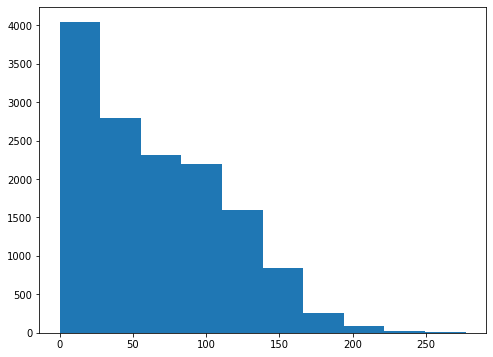

In [56]:
# chart of score2
dummy = plt.hist(df_train.P1)

In [57]:
#Let's go Modelling using LinearRegression Y = aX + b
X=df_train[['P1', 'P4', 'P7', 'P9', 'P12', 'P15', 'P21', 'P24']]
X = np.nan_to_num(X)
XX=np.repeat(1,len(X)).reshape(-1,1)
X=np.concatenate((XX,X),axis = 1)
y=df_train[['Unemployed']]
y = np.nan_to_num(y) 

In [58]:
XX=np.repeat(1,len(X))
XX.shape

(14196,)

In [59]:
#Fit model

modelA=LinearRegression().fit(X,y)

print("Intercept:", modelA.intercept_)
print("coef_B:", modelA.coef_)

### assess model performance
# i. scoring itself directly (not recommended, overrates performance)
print('R2 on itself: ', modelA.score(X, y))
# ii. scoring by a cross-validation
# https://scikit-learn.org/stable/modules/cross_validation.html
scores = cross_val_score(LinearRegression(), X, y, cv=4)
print('R2 by cval: ', scores)

Intercept: [5.74835811]
coef_B: [[ 0.          0.33446308 -0.00255476  1.92594152  0.81750281 -0.11433167
   0.37958072  1.64037216  1.68522263]]
R2 on itself:  0.4775648353389722
R2 by cval:  [0.60673771 0.52699198 0.49168966 0.04834107]


The evaluation of the model over itself using R2 value gave a poor result 0.47 

The R2 vy cval value gave quite good results 

**4. Summary**

If there were more people with a college degree in town T, how will it affect the result
for party P?
 Will the town S have the poll turnout above the state/region average?
 Which parties compete for the same voters?
 Which party changes the structure of its electorate the most from 2013 to 2017?

Overall correlation we noticed that P24,P29,P20,P21,P15,P12,P9, P7, P4 and P1 are major political partys and have chance to win the elections. We will therefore focus the rest of the analysis on the mentioned political partys.

Results show that catholics vote for political party P24, which is a catholic party

Retired people with part time job vote for P15, P20, P1 and P9 while retired without job would vote for P29, P21,P8 and P4 Unemployed people vote for P29, P21, P7 and P4

There is very low corelation for political partys P8, P16, P17, P18 between 2013 and 2017 meaning 
they probably have changes in their structure between 2013 and 2017

Men as well as Women have tendency to vote for party P29, P21, P15, P12, P8, P4, P1
Divorced People have the same tendency as well as Men and Women
People of age over 65 would vote for P1, P4, P21  while Roma People seem not have impact to the elections issues

Results show that educated people have tendency to vote for following political partys: P20, P15, P12, P9, P1 (red) meaning if there were more educated people political partys listed above would be advantaged.

Results from our clustering show that municipalities are shared only by political parties and voters in group 1 meaning they will never be won by political parties from other clusters



Finally, the evaluation of our LinearRegression model over itself using R2 value gave a poor result 0.47

The R2 vy cval value gave quite good results